# Problem 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lib_hcy_week5 import myfunctions as mf
from scipy.stats import t, norm

In [2]:
p1_data = pd.read_csv("problem1.csv")
p1_data.head()

,x
0,-0.002665
1,-0.045128
2,0.053635
3,0.010450
4,-0.016284


In [3]:
def cal_ES(var, sim_data):
  return -np.mean(sim_data[sim_data <= -var])

In [4]:
var_norm, dist_norm = mf.norm_VaR(p1_data)
es_norm = cal_ES(var_norm, dist_norm)
print("Under Normal Distribution, VaR is {:.4f}, ES is {:.4f}".format(round(var_norm, 4), round(es_norm, 4)))

Under Normal Distribution, VaR is 0.0757, ES is 0.0917


In [5]:
var_t, dist_t = mf.MLE_T_VaR(p1_data)
es_t = mf.cal_ES(var_t, dist_t)
print("Under Generalized T Distribution, VaR is {:.4f}, ES is {:.4f}".format(round(var_t, 4), round(es_t, 4)))

Under Generalized T Distribution, VaR is 0.0811, ES is 0.1185


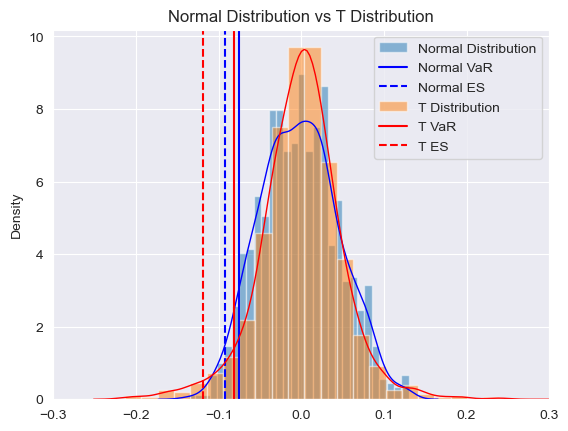

In [6]:
plt.hist(dist_norm, bins=30, density=True, alpha=0.5, label='Normal Distribution') # draw histogram, bins interval is 30, density is True for "the weights are normalized, so that the integral of the density over the range remains 1", alpha 0.5 is half transparent (1 is not transparent), label for legend
sns.kdeplot(dist_norm, color='blue', linewidth=1) # KDE smooth line graph shape
plt.axvline(-var_norm, label='Normal VaR', color='blue', linestyle='-') # draw vertical line at -var_norm
plt.axvline(-es_norm, label='Normal ES', color='blue', linestyle='--')
plt.hist(dist_t, bins=30, density=True, alpha=0.5, label='T Distribution')
sns.kdeplot(dist_t, color='red', linewidth=1)
plt.axvline(-var_t, label='T VaR', color='red', linestyle='-')
plt.axvline(-es_t, label='T ES', color='red', linestyle='--')
plt.xlim(-0.3, 0.3) # limit x to be -0.3 to 0.3, center the graph
plt.legend(loc='upper right') # keep the legend on upper right corner
plt.ylabel('Density') # y-axis label
plt.title('Normal Distribution vs T Distribution') # graph name
plt.show()

# Problem 2

In [ ]:
# test covariance estimation

In [ ]:
# test non PSD fixes

In [ ]:
# test simulation methods

In [ ]:
# test VaR calculation methods

In [ ]:
# test ES calculation
# already tested in Problem 1 code, var_t, dist_t = mf.MLE_T_VaR(p1_data), es_t = mf.cal_ES(var_t, dist_t)

# Problem 3

In [7]:
portfolio = pd.read_csv('portfolio.csv')
prices = pd.read_csv('DailyPrices.csv')

portfolioA = portfolio[portfolio['Portfolio'] == 'A'].drop('Portfolio', axis = 1)
portfolioB = portfolio[portfolio['Portfolio'] == 'B'].drop('Portfolio', axis = 1)
portfolioC = portfolio[portfolio['Portfolio'] == 'C'].drop('Portfolio', axis = 1)

all_assets = portfolio.drop('Portfolio', axis = 1) # the default drop drops rows, use axis = 1 to indicate drop a column
portfolioT = all_assets.groupby(["Stock"], as_index=False)["Holding"].sum() # as_index makes Stock column a real column, not index column

In [30]:
def cal_port_tDist(aPortfolio, prices):
  # step 1, collect historical data
  daily_price, holdings, port_value = mf.parsing_port(aPortfolio, prices)

  # step 2, calculate returns, default to be arithmatic
  asset_returns = mf.return_calculate(daily_price)
  asset_returns.drop("Date", axis=1, inplace=True) # 1 means modify on original df
  asset_returns_mean = asset_returns.mean()
  asset_returns = asset_returns - asset_returns_mean

  returns_R_U = asset_returns.copy()

  # step 3, transform rit to uit, using T distribution
  for asset in returns_R_U.columns.tolist(): # an array of stock names
    result = t.fit(asset_returns[asset], method="MLE")
    df = result[0]
    loc = result[1]
    scale = result[2]
    returns_R_U[asset] = t.cdf(asset_returns[asset], df=df, loc=loc, scale=scale)

  # step 4, transform uit to zit, not necessary if we use Spearman correlation
  returns_U_Z = pd.DataFrame(norm.ppf(returns_R_U), index=returns_R_U.index, columns=returns_R_U.columns) # keep the identifier for rows and columns the same

  # step 5, estimate correlation matrix, we use Spearman here
  spearman_corr_mtx = returns_U_Z.corr(method='spearman')
  std_vector = returns_U_Z.std() # simu_from_pca() only accept covariance matrix, we have to convert
  spearman_cov_mtx = spearman_corr_mtx * np.outer(std_vector, std_vector)

  # step 6, Monte Carlo random simulation, cholesky or PCA, we use PCA here
  simulations = mf.simu_from_pca(spearman_cov_mtx, 1000, 1)
  df_simu = pd.DataFrame(simulations, columns=returns_U_Z.columns)

  # step 7, convert back yit (simulated zit) to uit
  returns_Z_U = pd.DataFrame(norm.cdf(df_simu), index=df_simu.index, columns=df_simu.columns)

  returns_U_R = returns_Z_U.copy()

  # step 8, convert uit to rit, using the same parameters from step 3
  for asset in returns_U_R.columns.tolist():
      result = t.fit(asset_returns[asset], method="MLE")
      df = result[0]
      loc = result[1]
      scale = result[2]
      returns_U_R[asset] = t.ppf(returns_Z_U[asset], df=df, loc=loc, scale=scale)

  # step 9, calculate simulated portfolio returns
  actual_returns = np.add(returns_U_R, asset_returns_mean)
  latest_prices = daily_price.drop("Date", axis=1).tail(1).values.reshape(-1, 1)
  pchange = actual_returns * latest_prices.T
  holdings = holdings.values.reshape(-1, 1)
  simulated_returns = pchange @ holdings

  # step 10, calculate VaR
  var = mf.calculate_VaR(simulated_returns, alpha=0.05)

  # step 11, calculate ES
  es = mf.cal_ES(var, simulated_returns)[0]
  return var, es

In [32]:
var_A, es_A = cal_port_tDist(portfolioA, prices)
print(var_A, es_A)
var_B, es_B = cal_port_tDist(portfolioB, prices)
print(var_B, es_B)
var_C, es_C = cal_port_tDist(portfolioC, prices)
print(var_C, es_C)
var_T, es_T = cal_port_tDist(portfolioT, prices)
print(var_T, es_T)

/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


19388.13354107025 26337.260172560942


/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


-202.20160560359813 -202.20160560359543


/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/lib_hcy_week5/myfunctions.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[vars[i]] = p2[:,i]


25754.579343245565 32232.168008144832
-2175.909324247956 -2175.9093242479094


/Users/yanghaochen/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [53]:
def pca_percent_explain(sort_eigenvalues, percent_explain):
    n_eigenvalues = 0
    cum_var = np.cumsum(sort_eigenvalues) / np.sum(sort_eigenvalues) # returns an array with the variance explained by elements from 1st to 1st / 2nd / 3rd / 4th...
    for i in range(len(cum_var)):
        if cum_var[i] >= percent_explain:
            n_eigenvalues = i + 1
            break
    return n_eigenvalues

def simu_from_pca(cov_mtx, num_samples, percent_explain):
    eigenvalues, eigenvectors = np.linalg.eig(cov_mtx)
    p_idx = eigenvalues > 0 # only want those eigenvalues are non 0, as if it is zero, we remove everything related to that, including the eigenvalue in matrix lambda and its corresponding column in the
    # p_idx will return a numpy array of boolean values, indicating which eigenvalue is positive, and which eigenvalue is not
    pos_eigenvalues = eigenvalues[p_idx]
    pos_eigenvectors = eigenvectors[:, p_idx]
    # sort in descending order
    s_idx = np.argsort(pos_eigenvalues)[::-1] # return an array indicating the sequence for original input array
    sort_eigenvalues = eigenvalues[s_idx] # rearrange the eigenvalue array
    sort_eigenvectors = eigenvectors[:, s_idx] # rearrange the column of eigenvector corresponding to the change in eigenvalue array

    n_eigenvalues = pca_percent_explain(sort_eigenvalues, percent_explain)
    # print(n_eigenvalues)
    explain_eigenvalues = sort_eigenvalues[:n_eigenvalues] # only need the required eigenvalues enough to explain % set
    explain_eigenvectors = sort_eigenvectors[:,:n_eigenvalues] # only need the required eigenvectors enough to explain % set
    # np.random.seed(42)
    std_normals = np.random.normal(size=(n_eigenvalues, num_samples))

    # actual simulation
    sqrt_eigenvalues = np.sqrt(explain_eigenvalues) # calculate the square root of significant eigenvalues
    diag_sqrt_eigenvalues = np.diag(sqrt_eigenvalues) # create a diagonal matrix from the square root of eigenvalues
    transformation_matrix = np.dot(explain_eigenvectors, diag_sqrt_eigenvalues) # compute the transformation matrix 'B'
    multivariate_normal_samples = np.dot(transformation_matrix, std_normals) # generate the multivariate normal samples
    samples = np.transpose(multivariate_normal_samples) # transpose the result for the final output
    return samples

In [ ]:
def pca_sim(cov_mtx, n_draws, percent_explain):
    eigenvalues, eigenvectors = np.linalg.eig(cov_mtx)
    #Keep those positive eigenvalues and corresponding eigenvectors
    p_idx = eigenvalues > 1e-8
    eigenvalues = eigenvalues[p_idx]
    eigenvectors = eigenvectors[:, p_idx]
    #Sort
    s_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[s_idx]
    eigenvectors = eigenvectors[:, s_idx]

    n_eigenvalues = np.where((np.cumsum(eigenvalues)/np.sum(eigenvalues))>= percent_explain)[0][0] + 1
    #print(n_eigenvalues)
    eigenvectors = eigenvectors[:,:n_eigenvalues]
    eigenvalues = eigenvalues[:n_eigenvalues]
    std_normals = np.random.normal(size=(n_eigenvalues, n_draws))

    B = eigenvectors.dot(np.diag(np.sqrt(eigenvalues)))
    return np.transpose(B.dot(std_normals))

In [54]:
# step 1, collect historical data
daily_price, holdings, port_value = mf.parsing_port(portfolioB, prices)

# step 2, calculate returns, default to be arithmatic
asset_returns = mf.return_calculate(daily_price)
asset_returns.drop("Date", axis=1, inplace=True) # 1 means modify on original df
asset_returns_mean = asset_returns.mean()
asset_returns = asset_returns - asset_returns_mean

returns_R_U = asset_returns.copy()

# step 3, transform rit to uit, using T distribution
for asset in returns_R_U.columns.tolist():
  result = t.fit(asset_returns[asset], method="MLE")
  df = result[0]
  loc = result[1]
  scale = result[2]
  returns_R_U[asset] = t.cdf(asset_returns[asset], df=df, loc=loc, scale=scale)

# step 4, transform uit to zit, not necessary if we use Spearman correlation
returns_U_Z = pd.DataFrame(norm.ppf(returns_R_U), index=returns_R_U.index, columns=returns_R_U.columns) # keep the identifier for rows and columns the same

# step 5, estimate correlation matrix, we use Spearman here
spearman_corr_mtx = returns_U_Z.corr(method='spearman')
std_vector = returns_U_Z.std() # simu_from_pca() only accept covariance matrix, we have to convert
spearman_cov_mtx = spearman_corr_mtx * np.outer(std_vector, std_vector)
# print(spearman_cov_mtx)

# psd = mf.is_psd(spearman_cov_mtx)
# print(psd)

# step 6, Monte Carlo random simulation, cholesky or PCA, we use PCA here
simulations = simu_from_pca(spearman_cov_mtx, 1000, 1)
df_simu = pd.DataFrame(simulations, columns=returns_U_Z.columns)
# print(simulations)
# step 7, convert back yit (simulated zit) to uit
returns_Z_U = pd.DataFrame(norm.cdf(df_simu), index=df_simu.index, columns=df_simu.columns)

returns_U_R = returns_Z_U.copy()

# step 8, convert uit to rit, using the same parameters from step 3
for asset in returns_U_R.columns.tolist():
  result = t.fit(asset_returns[asset], method="MLE")
  df = result[0]
  loc = result[1]
  scale = result[2]
  returns_U_R[asset] = t.ppf(returns_Z_U[asset], df=df, loc=loc, scale=scale)

# step 9, calculate simulated portfolio returns
actual_returns = np.add(returns_U_R, asset_returns_mean)
latest_prices = daily_price.drop("Date", axis=1).tail(1).values.reshape(-1, 1)
pchange = actual_returns * latest_prices.T
holdings = holdings.values.reshape(-1, 1)
simulated_returns = pchange @ holdings
# print(simulated_returns)

# step 10, calculate VaR
var = mf.calculate_VaR(simulated_returns, alpha=0.05)
print(var)
# step 11, calculate ES
es = mf.cal_ES(var, simulated_returns)[0] # es is a data frame, we only need the value
print(es)

IndexError: index 0 is out of bounds for axis 0 with size 0